In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("dataset.csv")
df.head()
df.shape
df.info()
df.describe()
df.isnull().sum() #check if there are missing values in data

x = df["Text"]
y = df["language"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      22000 non-null  object
 1   language  22000 non-null  object
dtypes: object(2)
memory usage: 343.9+ KB


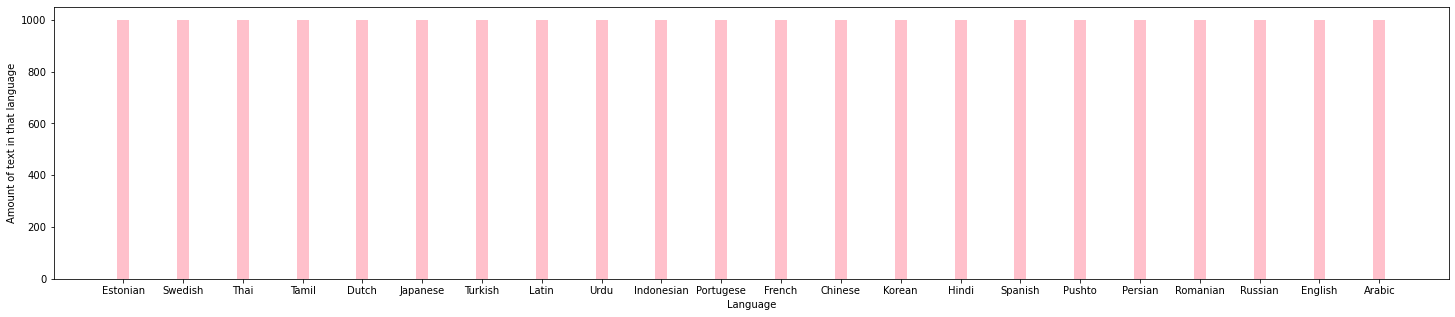

In [3]:
fig = plt.figure(figsize=(25, 5))
plt.bar(df["language"].unique(), list(df["language"].value_counts()), color='pink', width=0.2)
plt.xlabel("Language")
plt.ylabel("Amount of text in that language")
plt.show()
#we check how many texts in which language we have so we can see if we have a balanced data set.
#yes we do, each language has 1000 texts.

In [4]:
# helper function for vectorizing the given text, otherwise we can not predict it with the raw text
def vectorize(text, vectorizer, array):
    counter = 0
    for name in vectorizer.get_feature_names_out():
        if text.lower().count(name):
            array[0][counter] = text.lower().count(name)
        counter+= 1
    return array

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
x_rows, x_cols = X.shape
empty_features = np.zeros((1, x_cols))

In [6]:
#MultinomialNB classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

#hyperparameter tuning
clf = MultinomialNB()
param={'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
grid = GridSearchCV(clf, param, scoring='accuracy', cv=10, return_train_score=True)
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_)

{'alpha': 0.0001}


In [15]:
#fitting the model with the best parameter
clf = MultinomialNB(alpha = 0.0001)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

#predict any text, just assign your input to the text variable
text = ""
print(clf.predict(vectorize(text, vectorizer, empty_features))) # you can predict any text just by changing the text variable

0.9622727272727273
['Dutch']


In [16]:
#KNN classifier
from sklearn.neighbors import KNeighborsClassifier

#hyperparameter tuning, find the best k value with GridSearch
knn = KNeighborsClassifier()
k_range = list(range(1, 21))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'n_neighbors': 5}


In [19]:
knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_["n_neighbors"])
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.5477272727272727
